In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import pandas as pd
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import dlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from imutils import face_utils

os.environ["OPENCV_OPENCL_RUNTIME"] = "disabled"

In [5]:
# Function to save the images
def save_image(image, output_dir, filename):
    os.makedirs(output_dir, exist_ok=True)
    cv2.imwrite(os.path.join(output_dir, filename), image)

# Function to resize the images to (64x64)
def resize_image(image, width=640, height=640):
    return cv2.resize(image, (width, height))

In [32]:
name_classes = ["Drowsy", "Neutral"]

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="model_cnn.tflite")
interpreter.allocate_tensors()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# face landmark
predictor_path = "shape_predictor_68_face_landmarks.dat" 
predictor = dlib.shape_predictor(predictor_path)

In [3]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
input_details

[{'name': 'serving_default_conv2d_54_input:0',
  'index': 0,
  'shape': array([ 1, 64, 64,  1], dtype=int32),
  'shape_signature': array([-1, 64, 64,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

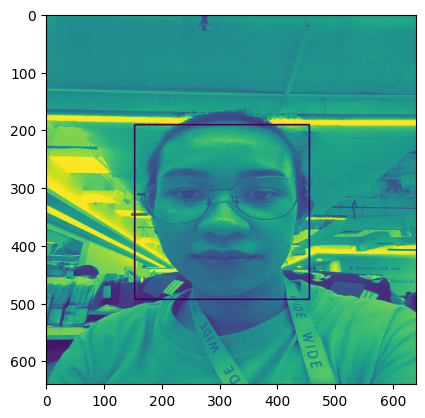

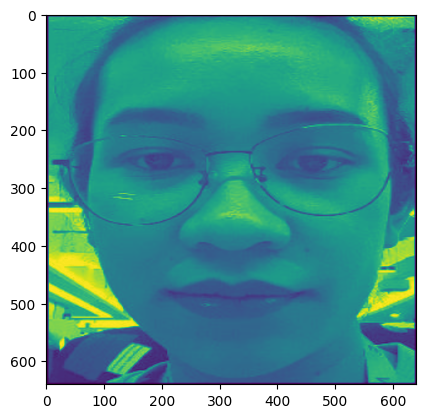

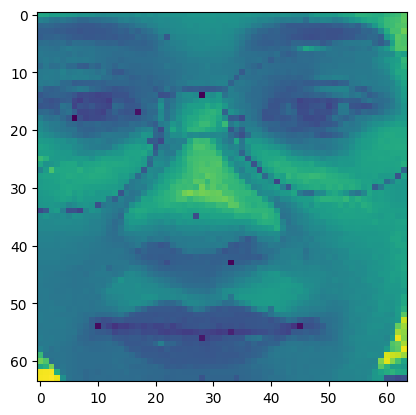

In [20]:
image_path = os.path.join("Dataset/raw/Neutral/new_real-36-_jpg.rf.8dd2f3284638a5aaadbd5a9629777d1c.jpg")
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

for (x, y, w, h) in faces:
    cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
imgplot = plt.imshow(gray)
plt.show()

x, y, w, h = faces[0]
crop_img = gray[y:y+h, x:x+w]

crop_img = resize_image(crop_img)

imgplot = plt.imshow(crop_img)
plt.show()

facial_landmarks = []
for (x, y, w, h) in faces:
    h , w = crop_img.shape
    face_rect = dlib.rectangle(0, 0, 0 + w, 0 + h)
    landmarks = predictor(crop_img, face_rect)
    landmarks = face_utils.shape_to_np(landmarks)
    facial_landmarks.append(landmarks)

    feature_indices = list(range(18, 68))
    feature_points = np.array([(landmarks[i][0], landmarks[i][1]) for i in feature_indices])

    for (x, y) in feature_points:
        cv2.circle(crop_img, (x, y), 2, (0, 255, 0), -1)

x, y, w, h = cv2.boundingRect(feature_points)
crop_img = crop_img[y:y + h, x:x + w]
crop_img = resize_image(crop_img, 64, 64)

imgplot = plt.imshow(crop_img)
plt.show()

In [28]:
image_tocnn = cv2.resize(crop_img, (input_details[0]['shape'][2], input_details[0]['shape'][1]))
image_tocnn = np.expand_dims(np.array(image_tocnn, dtype=np.float32), axis=0)
image_tocnn /= 255.0  # Normalize to [0, 1]
image_tocnn = image_tocnn.reshape(input_details[0]['shape'])

In [34]:
# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], image_tocnn)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class
predicted_class = np.argmax(output_data[0])

print("Predicted class:", name_classes[predicted_class])

Predicted class: Neutral
